# Example: $\min_{x\in[-M, M]} f(x), \text{s.t. } f(x)\leq0$

In [15]:
%load_ext autoreload
%autoreload 2
import numpy as np
from vabo import safe_optimizer
from vabo import util
from vabo import optimization_problem
from vabo import constrained_bo
import matplotlib.pyplot as plt
from vabo import violation_aware_bo
from vabo import vabo_plot
from vabo import run_util
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plot some sampled functions from 1-d GP.

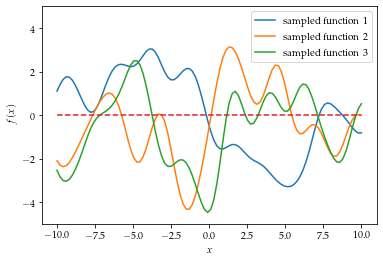

In [16]:
config_1 = util.get_config('GP_sample_single_func')
config_2 = util.get_config('GP_sample_single_func')
config_3 = util.get_config('GP_sample_single_func')
vabo_plot.plot_sampled_data([config_1, config_2, config_3])


# Run one instance to demonstrate the optimization process.

In [24]:
GP_1d_problem_config = util.get_config('GP_sample_single_func')

optimizer_base_config = {
    'noise_level':0.0,
    'kernel_var':0.1,
    'train_noise_level': 0.0,
    'problem_name':'GP_sample_single_func',
    'normalize_input': False,
    'total_eval_num': 100
}

safe_bo_config = optimizer_base_config.copy()
safe_bo_config.update({
    'optimizer_type': 'safe_bo'
})

vabo_config = optimizer_base_config.copy()
vabo_config.update({
        'total_vio_budgets': np.array([10.0]),
        'prob_eps': 1e-2,
        'beta_0': 10,
        'optimizer_type': 'violation_aware_bo',
        'single_max_budget': np.array([20.0])
        }
)

cbo_config = optimizer_base_config.copy()
cbo_config.update({
    'optimizer_type': 'constrained_bo'
})

safe_opt, safe_bo_best_obj_list, safe_bo_total_cost_list = run_util.get_optimizer(safe_bo_config, GP_1d_problem_config)
constrained_opt, constrained_bo_best_obj_list, constrained_bo_total_cost_list = \
    run_util.get_optimizer(cbo_config,
                           GP_1d_problem_config)
violation_aware_opt, violation_aware_bo_best_obj_list, violation_aware_bo_total_cost_list = \
    run_util.get_optimizer(vabo_config, GP_1d_problem_config)
true_value = GP_1d_problem_config['obj'](safe_opt.parameter_set)

## Run the following block repeatedly to see the optimization procedure.

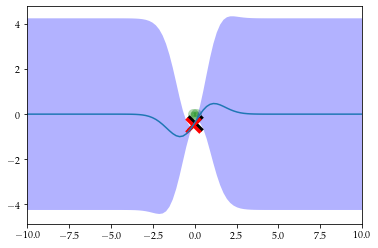

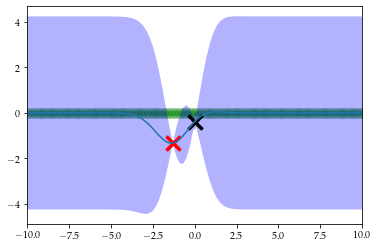

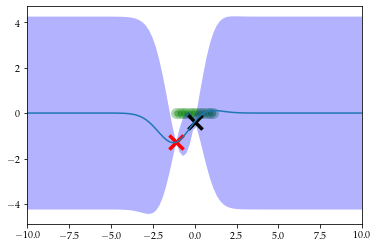

In [25]:
if True:
# run different optimization step by step
#for _ in range(optimizer_base_config['total_eval_num']):
    y_obj, constr_vals = safe_opt.make_step()
    safe_bo_total_cost_list.append(safe_opt.cumu_vio_cost)
    safe_bo_best_obj_list.append(safe_opt.best_obj)
    
    y_obj, constr_vals = constrained_opt.make_step()
    constrained_bo_total_cost_list.append(constrained_opt.cumu_vio_cost)
    constrained_bo_best_obj_list.append(constrained_opt.best_obj)
    y_obj, constr_vals = violation_aware_opt.make_step()
    violation_aware_bo_total_cost_list.append(violation_aware_opt.cumu_vio_cost)
    violation_aware_bo_best_obj_list.append(violation_aware_opt.best_obj)

    safe_opt.opt.compute_safe_set()
    vabo_plot.plot_gp_1d(safe_opt.gp_obj, safe_opt.parameter_set, safe_opt.parameter_set[safe_opt.opt.S], is_safe_opt=True)
    vabo_plot.plot_gp_1d(constrained_opt.gp_obj, constrained_opt.parameter_set, constrained_opt.parameter_set)
    vabo_plot.plot_gp_1d(violation_aware_opt.gp_obj, violation_aware_opt.parameter_set, violation_aware_opt.S, save_path='../figs/vabo_sample', save_format='png')
    

# Multiple runs and get statistics of results.

In [75]:
%load_ext autoreload
%autoreload 2
total_eva_num = 30
vio_budgets_list = [0.0, 10.0, 20.0]
safe_cost_lists = []
safe_simple_regret_lists = []

con_bo_cost_lists = []
con_bo_simple_regret_lists = []

vabo_cost_lists = []
vabo_simple_regret_lists = []

vabo_cost_lists_set = [[] for _ in range(len(vio_budgets_list))]
vabo_simple_regret_lists_set = [[] for i in range(len(vio_budgets_list))]

for _ in range(total_eva_num):
    problem_name = 'GP_sample_single_func'
    problem_config = util.get_config(problem_name)
    try:
        safe_costs, safe_objs = run_util.get_bo_result(safe_bo_config, problem_config, plot=False)
        con_costs, con_objs = run_util.get_bo_result(cbo_config, problem_config, plot=False)
        vabo_costs_tmp = []
        vabo_objs_tmp = []
        for budget_id in range(len(vio_budgets_list)):
            budget = vio_budgets_list[budget_id]
            vabo_config['total_vio_budgets'] = np.array([budget])
            vabo_costs, vabo_objs = run_util.get_bo_result(vabo_config, problem_config,
                                                           plot=False)
            vabo_costs_tmp.append(vabo_costs)
            vabo_objs_tmp.append(vabo_objs)

        safe_cost_lists.append(safe_costs)
        safe_simple_regret_lists.append(np.array(safe_objs)-problem_config['f_min'])

        con_bo_cost_lists.append(con_costs)
        con_bo_simple_regret_lists.append(np.array(con_objs)-problem_config['f_min'])
        
        for budget_id in range(len(vio_budgets_list)):
            vabo_cost_lists_set[budget_id].append(vabo_costs_tmp[budget_id])
            vabo_simple_regret_lists_set[budget_id].append(np.array(vabo_objs_tmp[budget_id])-problem_config['f_min'])
    except:
        continue



safe_ave_cost_arr = np.mean(np.array(safe_cost_lists), axis=0)
safe_ave_simple_regret_arr = np.mean(np.array(safe_simple_regret_lists), axis=0)

con_ave_cost_arr = np.mean(np.array(con_bo_cost_lists), axis=0)
con_ave_simple_regret_arr = np.mean(np.array(con_bo_simple_regret_lists), axis=0)

vabo_ave_cost_arr_set = []
vabo_ave_simple_regret_arr_set = []
for budget_id in range(len(vio_budgets_list)):
    vabo_ave_cost_arr_set.append((np.mean(np.array(vabo_cost_lists_set[budget_id]), axis=0), vio_budgets_list[budget_id]))
    vabo_ave_simple_regret_arr_set.append((np.mean(np.array(vabo_simple_regret_lists_set[budget_id]), axis=0), vio_budgets_list[budget_id]))

np.savez('../results/test_GP_sample_result.npz',
         safe_ave_cost_arr,
         safe_ave_simple_regret_arr,
         con_ave_cost_arr,
         con_ave_simple_regret_arr,
         vabo_ave_cost_arr_set,
         vabo_ave_simple_regret_arr_set,
         np.array(safe_cost_lists),
         np.array(safe_simple_regret_lists),
         np.array(con_bo_cost_lists),
         np.array(con_bo_simple_regret_lists),
         np.array(vabo_cost_lists_set),
         np.array(vabo_simple_regret_lists_set)
         )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read and plot the statistical results after multiple runs.

['Safe BO', 'Generic Constrained BO', 'Violation Aware BO 0.0', 'Violation Aware BO 10.0', 'Violation Aware BO 20.0']


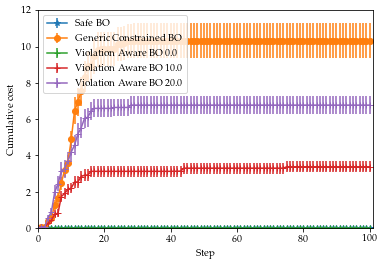

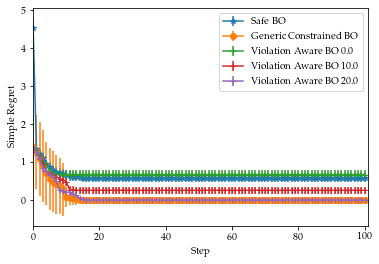

In [19]:
read_result = True
if read_result:
    data = np.load('../results/test_GP_sample_result.npz', allow_pickle=True)

    safe_ave_cost_arr = data['arr_0']
    safe_ave_simple_regret_arr = data['arr_1']
    con_ave_cost_arr = data['arr_2']
    con_ave_simple_regret_arr = data['arr_3']
    vabo_ave_cost_arr_set = data['arr_4']
    vabo_ave_simple_regret_arr_set = data['arr_5']

    safe_cost_lists_arr = data['arr_6']
    safe_simple_regret_lists_arr = data['arr_7']
    con_bo_cost_lists_arr = data['arr_8']
    con_bo_simple_regret_lists_arr = data['arr_9']
    vabo_cost_lists_arr = data['arr_10']
    vabo_simple_regret_lists_arr = data['arr_11']

vabo_plot.plot_results(safe_ave_cost_arr, safe_ave_simple_regret_arr, con_ave_cost_arr, con_ave_simple_regret_arr, vabo_ave_cost_arr_set,
            vabo_ave_simple_regret_arr_set, safe_cost_lists_arr, safe_simple_regret_lists_arr,
            con_bo_cost_lists_arr, con_bo_simple_regret_lists_arr, vabo_cost_lists_arr,
            vabo_simple_regret_lists_arr)

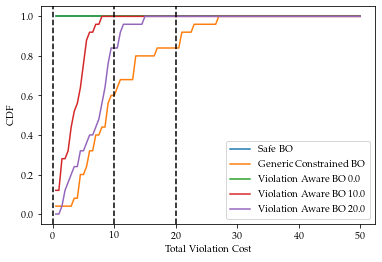

In [22]:
vabo_plot.cdf_plot(safe_cost_lists_arr[:, -1, 0])
vabo_plot.cdf_plot(con_bo_cost_lists_arr[:, -1, 0])
vabo_plot.cdf_plot(vabo_cost_lists_arr[0, :, -1, 0])
vabo_plot.cdf_plot(vabo_cost_lists_arr[1, :, -1, 0])
vabo_plot.cdf_plot(vabo_cost_lists_arr[2, :, -1, 0])

plt.legend(['Safe BO', 'Generic Constrained BO','Violation Aware BO $0.0$', 'Violation Aware BO $10.0$', 'Violation Aware BO $20.0$'])
plt.xlabel('Total Violation Cost')
plt.ylabel('CDF')
plt.axvline(x=0, linestyle='--', color='0')
plt.axvline(x=10, linestyle='--', color='0')
plt.axvline(x=20, linestyle='--', color='0')
plt.savefig('../figs/total_vio_cost_CDF.pdf', format='pdf')


## plot the scatter figure of simple regret $\min_{f(x_t)\leq0}f(x_t)-\min_{f(x)\leq0} f(x) $ v.s. violation cost

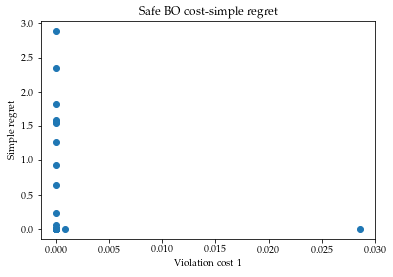

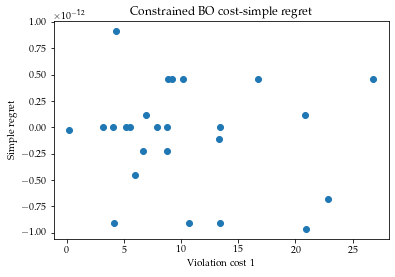

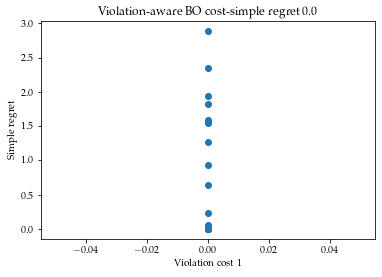

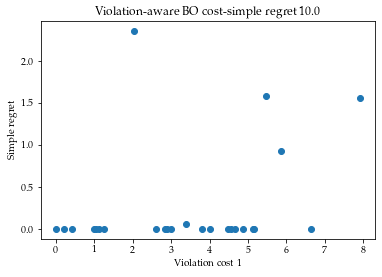

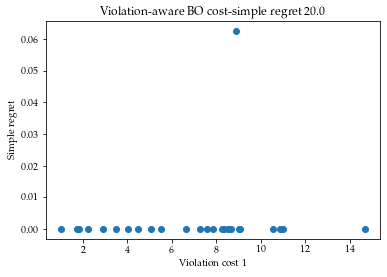

In [26]:
vabo_plot.plot_cost_SR_scatter(safe_cost_lists_arr, safe_simple_regret_lists_arr, 'Safe BO cost-simple regret')
vabo_plot.plot_cost_SR_scatter(con_bo_cost_lists_arr, con_bo_simple_regret_lists_arr, 'Constrained BO cost-simple regret')
vabo_plot.plot_cost_SR_scatter(vabo_cost_lists_arr[0], vabo_simple_regret_lists_arr[0], 'Violation-aware BO cost-simple regret 0.0')
vabo_plot.plot_cost_SR_scatter(vabo_cost_lists_arr[1], vabo_simple_regret_lists_arr[1], 'Violation-aware BO cost-simple regret 10.0')
vabo_plot.plot_cost_SR_scatter(vabo_cost_lists_arr[2], vabo_simple_regret_lists_arr[2], 'Violation-aware BO cost-simple regret 20.0')
